Dry adiabatic lapse rate is
$$
\Gamma_d \approx 9.8 K km^{-1}.
$$
Anything **less** is stable (or **more** if the lapse rate is taken **negative**).


[set_matplotlib_formats](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#IPython.display.set_matplotlib_formats)

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from cartopy import crs
import matplotlib.pyplot as plt
from matplotlib import gridspec as gs

In [98]:
import sys
sys.path.append('/home/arno/Documents/code/python')
import helpers as hh
from data import WRF
import laplace as lapl
from plots import Coquimbo

coq = Coquimbo()

In [2]:
import sys
sys.path.append('/home/arno/code/')
import condor
condor.enable_sshfs_import(port=8900)
# condor.enable_github_import()

import helpers as hh
from data import WRF
import laplace as lapl
from plots import Coquimbo

coq = Coquimbo()

loading helpers from sshfs host localhost
loading data from sshfs host localhost
loading data.WRF_mpi from sshfs host localhost
loading laplace from sshfs host localhost
loading plots from sshfs host localhost


In [3]:
%matplotlib nbagg

In [88]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png', 'pdf')

In [4]:
D = pd.HDFStore('/HPC/arno/data/station_data_new.h5')

In [5]:
sta = WRF.Files.stations()

In [6]:
sta_28_33S = sta[(sta.lat.astype(float)>-33) & (sta.lat.astype(float)<-28)] # used to be s

In [7]:
T2 = hh.stationize(D['ta_c'].xs('prom', 1, 'aggr').drop('10', 1, level='elev'))
T = xr.DataArray(T2, dims=('time', 'space')).dropna('time', 'all').dropna('space', 'all')
Z = xr.DataArray(sta_28_33S['elev'].to_frame(), dims=('space', 'var')).dropna('space').astype(float)

In [8]:
sta_in_dom = sta_28_33S.index.intersection(T.space) # used to be si

In [9]:
Tr = T.sel(space=sta_in_dom).resample('h', 'time')

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="h").mean() 
  """Entry point for launching an IPython kernel.
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [140]:
L = lapl.LRLR(sta_28_33S, weights=lapl.LRLR.gauss(20000))

In [141]:
L.regress(Z, Tr.sel(time='2016-06'), 0.)

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.333547258435862e-23 / 1.1102230246251565e-16
  RuntimeWarning)


In [104]:
p0 = L.p.sel(var='elev').values

In [106]:
p1 = L.p.sel(var='elev').values

In [142]:
ll = sta.loc[L.p.space][['lon', 'lat']].astype(float).as_matrix().T

In [143]:
count = Tr.sel(space=si).count('time')
count = count / count.max() * 50

<IPython.core.display.Javascript object>


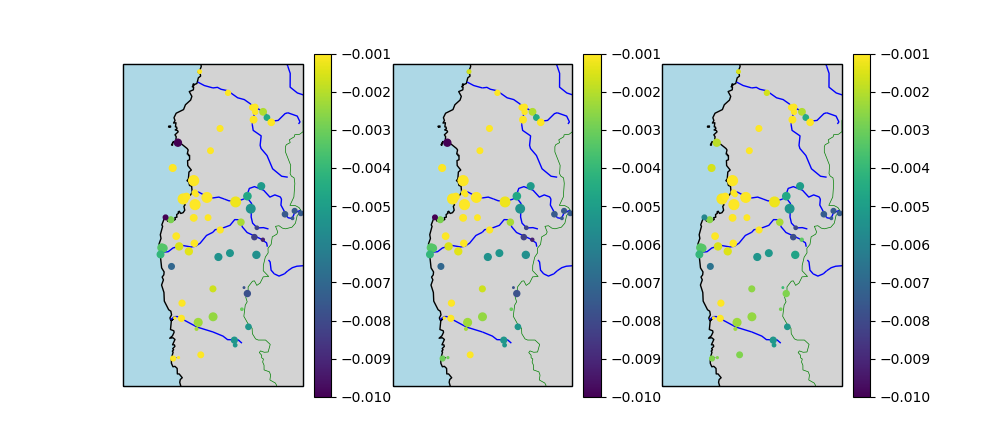

In [108]:
mi, ma = -0.01, -0.001

fig, axs = plt.subplots(1, 3, subplot_kw={'projection': crs.PlateCarree()})
plt.sca(axs[0])
plt.scatter(*ll, c=p0.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[0])

plt.sca(axs[1])
plt.scatter(*ll, c=p1.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[1])

plt.sca(axs[2])
plt.scatter(*ll, c=L.p.sel(var='elev').values.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[2])

In [22]:
from scipy.sparse import csgraph

In [145]:
%matplotlib nbagg

In [128]:
x = Tr.sel(time='2016', space=s.index[s.index.str.contains('MET')])
x.coords['hour'] = ('time', x.time.dt.hour)

In [111]:
s[s.index.str.contains('MET')]

full        lon        lat  elev                first  \
station                                                                
MET3CH    Chiguinto  -70.32978  -28.83476  1063  2009-12-09 17:35:00   
MET3LA     La Arena  -70.27849  -28.91144  1209  2010-04-19 00:20:00   
MET3LH    La Huerta  -70.47333  -28.77642   872  2010-09-23 10:30:00   
MET3LM   La Mesilla  -70.43542  -28.83674   961  2009-12-09 17:45:00   
MET3LP     La Pampa  -70.22005  -28.97483  1363  2010-02-14 13:10:00   
MET3RM    Ramadilla  -70.43668  -28.77159   880  2009-12-09 17:40:00   
MET3SF    San Felix  -70.45712  -28.94014  1222  2010-01-06 12:50:00   

                        last  
station                       
MET3CH   2017-09-24 00:00:00  
MET3LA   2017-09-24 00:00:00  
MET3LH   2017-09-24 00:00:00  
MET3LM   2017-09-24 00:00:00  
MET3LP   2017-09-24 00:00:00  
MET3RM   2017-09-24 00:00:00  
MET3SF   2017-09-24 00:00:00

<IPython.core.display.Javascript object>


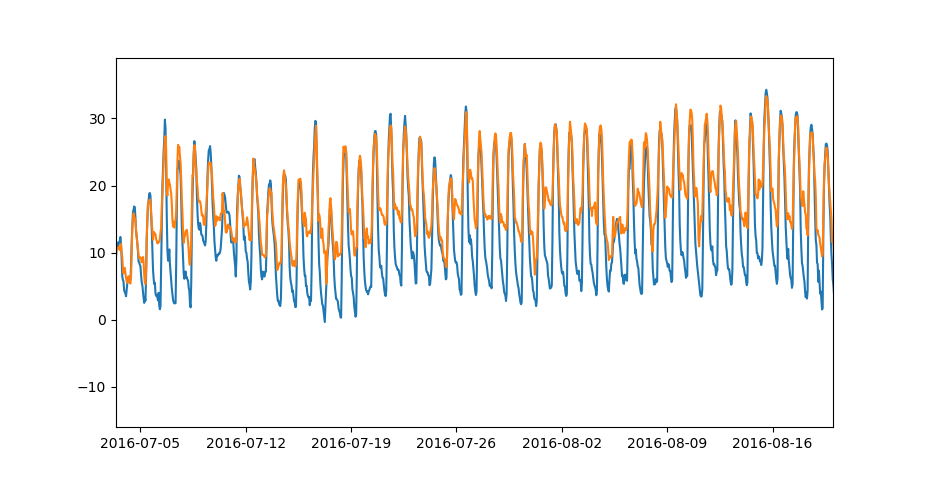

In [130]:
plt.figure()
plt.plot(x.time, x.sel(space='MET3LH').values)
plt.plot(x.time, x.sel(space='MET3CH').values)

The values of the (average) lapse rate in the Huasco value are (inverted) outliers mostly because of one station which doesn't seem to cool as much at night - **if that data is correct**.

In [10]:
x, y, r = lapl.LRLR.test(init=True)

In [11]:
r = Out[7]

In [12]:
r.p

<xarray.DataArray (time: 2, space: 2, var: 2)>
array([[[ 3.067698, -0.030556],
        [-1.038407,  1.035337]],

       [[ 0.999622,  2.003755],
        [-4.976419,  2.978723]]])
Coordinates:
  * space    (space) int64 0 1
  * var      (var) <U4 'x' 'icpt'
Dimensions without coordinates: time

In [16]:
I = np.identity(2)

In [17]:
I

array([[1., 0.],
       [0., 1.]])

In [22]:
(lambda d:d*.5+I)(1-I)

array([[1. , 0.5],
       [0.5, 1. ]])

In [79]:
ds = xr.open_dataset('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_0.nc')

In [14]:
view.run('/sata1_ceazalabs/arno/HPC/uvHome/code/python/parallel.py')

<AsyncResult: execute:finished>

In [11]:
import sys
from imp import reload
sys.path.append('/sata1_ceazalabs/arno/HPC/uvHome/code/python')
import mpicdf
from ipyparallel import Client
rc = Client(profile='mpi')
view = rc[:]
view.activate() # <- activate magics
view.block = True
# view.block = False
view.run('/sata1_ceazalabs/arno/HPC/uvHome/code/python/parallel.py')

In [15]:
%px d = mpicdf.Data('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_10.nc', var='T', dim='start')
%px x = d.np_op({'Time': 'mean'})
tm = mpicdf.concat_np(view, 'x', 0)

In [27]:
%px x = d.np_op({'Time': 'mean'})

In [28]:
tm = mpicdf.concat_np(view, 'x', 0)

In [31]:
%px d = mpicdf.Data('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_10.nc', var='GP', dim='start')
%px x = d.np_op({'Time': 'mean'})
gm = mpicdf.concat_np(view, 'x', 0)

In [47]:
lr = np.mean(np.diff(tm, 1, 1) / np.diff(gm, 1, 1), 0)

In [50]:
dlr = np.diff(lr, 1, 0)

<IPython.core.display.Javascript object>


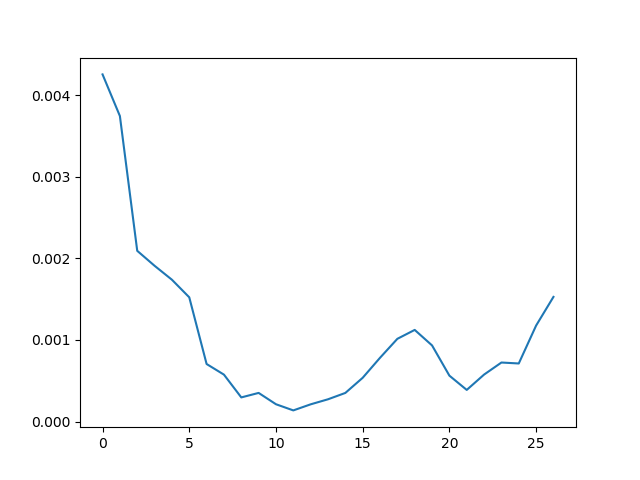

In [59]:
plt.figure()
plt.plot(np.abs(dlr.reshape((27, -1))).mean(1))

In [102]:
%px lon = d.netcdf['XLONG'][0, :, :]
lon = view['lon'][0]
%px lat = d.netcdf['XLAT'][0, :, :]
lat = view['lat'][0]

In [161]:
reload(condor)
coq = condor.Coquimbo()

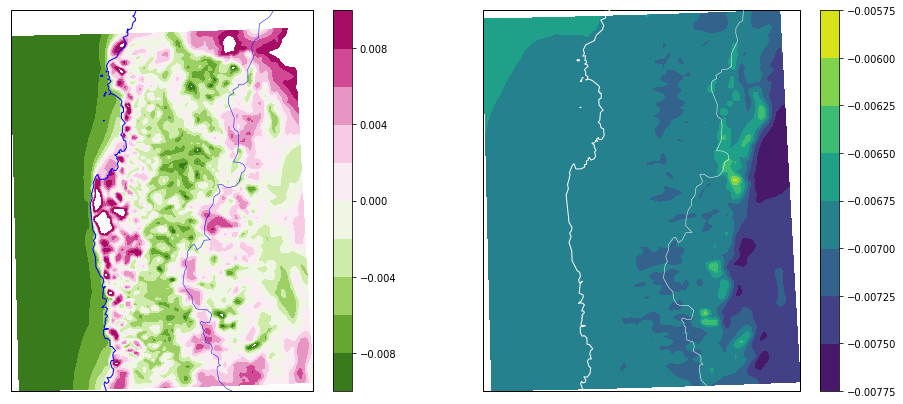

In [162]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': crs.PlateCarree()}, figsize=(16, 7))

plt.sca(axs[0])
plt.contourf(lon, lat, lr[0, :, :], np.arange(-.01, .011, .002), cmap='PiYG_r')
plt.colorbar()
coq(plt.gca(), lines_only=True, colors=['b'])

plt.sca(axs[1])
plt.contourf(lon, lat, lr[12, :, :], cmap='viridis')
plt.colorbar()
coq(plt.gca(), lines_only=True, colors=['w'])

Lapse rates as computed from the temperature differences in the lowest two layers (left) and layers 11 and 12 (right). The data are means over all WRF simulations between 2016-06-12 and 2016-08-017.

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1073852405565886e-22 / 1.1102230246251565e-16
  RuntimeWarning)


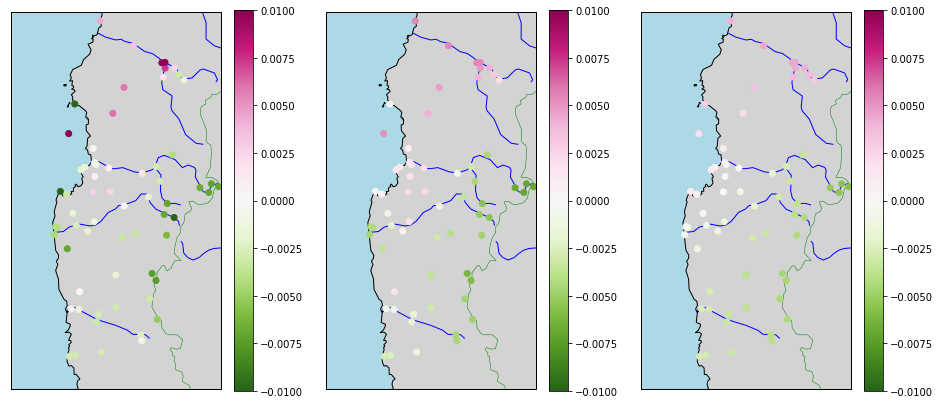

In [165]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': crs.PlateCarree()}, figsize=(16, 7))

for i, rad in enumerate([20000, 50000, 100000]):
    L = lapl.LRLR(s, weights=lapl.LRLR.gauss(rad))
    L.regress(Z, Tr.sel(time=slice('2016-06-12', '2016-08-17')), 0.)

    plt.sca(axs[i])
    plt.set_cmap('PiYG_r')
    plt.scatter(*ll, c=L.p.sel(var='elev').values.flatten(), transform=crs.PlateCarree(), vmin=-.01, vmax=.01)
    plt.colorbar()
    coq(plt.gca())

Lapse rates as a result of linear regression with distance-based weighting, using all available data (all timesteps). From left to right, the weights are a gaussian of distance with a *half width at half maximum (HWHM)* of 20, 50 and 100 km.

In [197]:
lr = (lambda x: x['T'] / x['GP'])(ds.isel(bottom_top=slice(0, 2)).diff('bottom_top').squeeze())
ll = sta.loc[lr.station][['lon', 'lat']].astype(float).as_matrix().T

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:127: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


In [327]:
L = lapl.LRLR(sta_28_33S, weights=lambda x: x*np.zeros_like(x)+np.ones_like(x))

In [188]:
a = []
for h in range(24):
    L.regress(Z, Tr.sel(time=Tr.indexes['time'].hour==h), 0.)
    a.append(L.p.sel(var='elev')[0, 0].item())

lr0 = lr.sel(start=lr.indexes['start'].hour == 20)
lr0.coords['hour'] = ('Time', lr0.Time % 24)

In [11]:
def by_hour(L, x, h):
    L.regress(Z, x.sel(time=x.indexes['time'].hour==h), 0.)
    return L.p.sel(var='elev').squeeze()

In [ ]:
b = [by_hour(L, Tr.sel(space=['LSC', 'CGR']), h)[0].item() for h in range(24)]

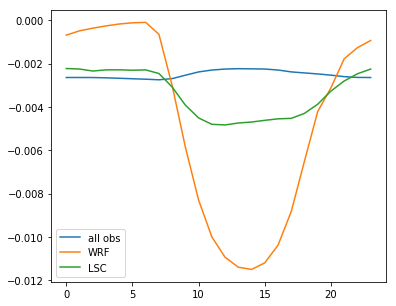

In [337]:
plt.figure(figsize=(6, 5))
plt.plot(a, label='all obs')
plt.plot(np.roll(lr0.groupby('hour').mean(), -4), label='WRF')
plt.plot(b, label='LSC')
plt.legend();

Daily cycle of lapse rates: *all obs* - using linear regression without any weighting or regularization and using all stations; *WRF* - using the difference between the two lowest model layes, interpolated to station locations and averaged; *LSC* - using unweighted linear regression only between the stations *LSC* and *CGR*.

In [343]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(20000))
b = xr.concat([by_hour(L, Tr, h) for h in range(24)], 'hour')

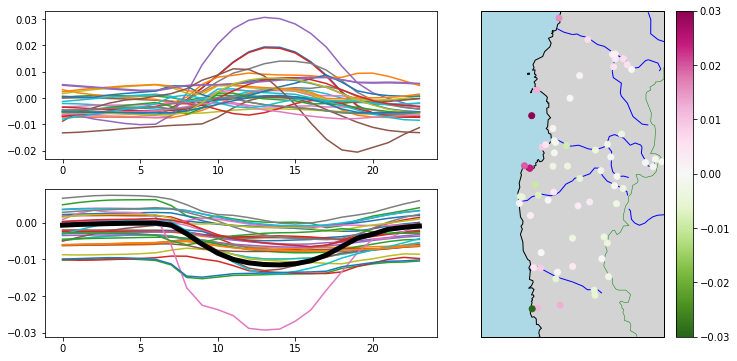

In [344]:
fig = plt.figure(figsize=(12, 6))
g = gs.GridSpec(2, 5)

l = b.sel(hour=[0, 12]).diff('hour').values > 0

plt.subplot(g[0, :3])
pl = plt.plot(b.sel(space=l.flatten()));

plt.subplot(g[1, :3], sharex=pl[0].axes)
plt.plot(b.sel(space=~l.flatten()))
plt.plot(np.roll(lr0.groupby('hour').mean(), -4), linewidth=5, color='k')

plt.subplot(g[:, 3:], projection=crs.PlateCarree())
plt.scatter(*ll, c=b.sel(hour=[0, 12]).diff('hour').values.flatten(), vmin=-.03, vmax=.03)
plt.colorbar()
coq(plt.gca())

Daily cycles of lapse rates in observations by location, computed with the gaussian weight kernel with radius 20 km.   
**Left**: The top panel shows all stations with the difference between 12h and 0h positive, the bottom panel with the same difference negative. The thick black line is the average of the WRF lapse rate (as described above).    
**Right**: The same difference (12h - 0h) plotted by station.

In [338]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(50000))
b = xr.concat([by_hour(L, Tr, h) for h in range(24)], 'hour')

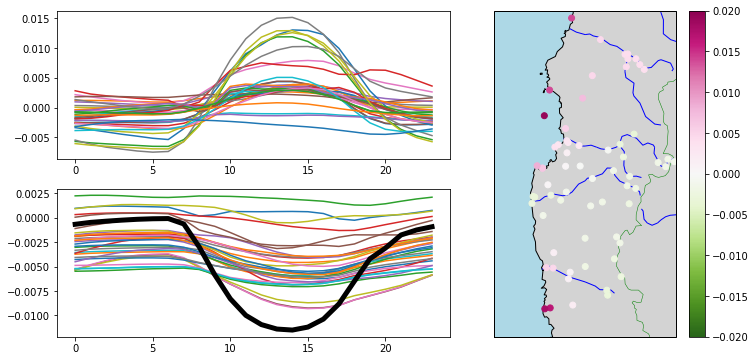

In [342]:
fig = plt.figure(figsize=(12, 6))
g = gs.GridSpec(2, 5)

l = b.sel(hour=[0, 12]).diff('hour').values > 0

plt.subplot(g[0, :3])
pl = plt.plot(b.sel(space=l.flatten()));

plt.subplot(g[1, :3], sharex=pl[0].axes)
plt.plot(b.sel(space=~l.flatten()));
plt.plot(np.roll(lr0.groupby('hour').mean(), -4), linewidth=5, color='k')

plt.subplot(g[:, 3:], projection=crs.PlateCarree())
plt.scatter(*ll, c=b.sel(hour=[0, 12]).diff('hour').values.flatten(), vmin=-.02, vmax=.02)
plt.colorbar()
coq(plt.gca())

Same plot as above, but with a 50 km gaussian weight kernel.

In [198]:
condor.reload(lapl)

reloaded laplace from sshfs host localhost


In [10]:
def by_hour(L, x, h):
    L.regress(Z, x.sel(time=x.indexes['time'].hour==h), 0.1)
    return L.p.sel(var='elev').squeeze()

In [11]:
d = lapl.LRLR.distance_matrix(sta)
D = lapl.LRLR.nearest_neighbor(Tr, distances=d)

In [12]:
L = lapl.LRLR(distances=d, nearest=D, laplacian=lapl.LRLR.gauss(20000))
a = xr.concat([by_hour(L, Tr, h) for h in range(24)], 'hour')

In [13]:
ll = sta.loc[a.space][['lon', 'lat']].astype(float).as_matrix().T

In [188]:
lr0 = lr.sel(start=lr.indexes['start'].hour == 20)
lr0.coords['hour'] = ('Time', lr0.Time % 24)

In [14]:
def amp(x):
    h, l = x.argmax('hour'), x.argmin('hour')
    return (x.isel(hour=h) - x.sel(hour=l)) * (((h > 10) & (h < 18)) * 2 - 1)

In [181]:
l = amp(a).values
b = xr.concat([by_hour(L, Tr.isel(space=l>0), h) for h in range(24)], 'hour')
c = xr.concat([by_hour(L, Tr.isel(space=l<0), h) for h in range(24)], 'hour')

In [15]:
from collections import Counter

In [16]:
c = Counter([tuple(i.values) for i in D.T])
ties = dict([D.space[np.array(k).astype(bool)].values for k, v in c.items() if v>1])

<IPython.core.display.Javascript object>


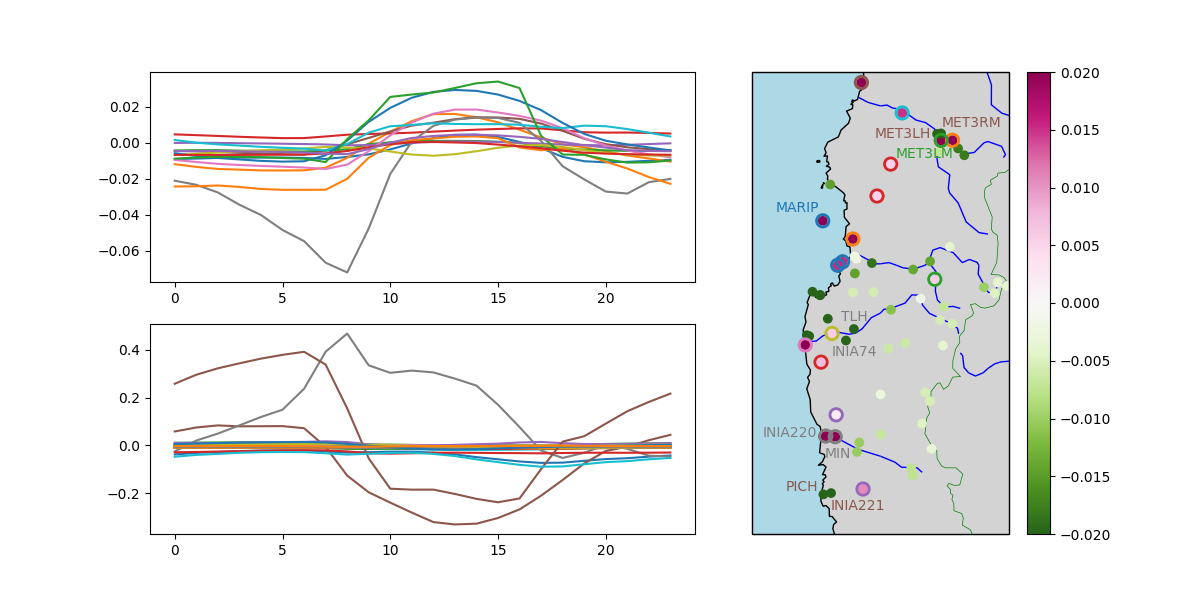

In [46]:
def drop(x):
    return x.drop([v for k, v in ties.items() if k in x.space.values], 'space')

def plot_get_colors(ax, x, ties, **kwargs):
    pl = ax.plot(x, **kwargs)
    cols = {k: pl[i].get_color() for i, k in enumerate(x.space.values)}
    cols.update([(v, cols[k]) for k, v in ties.items() if k in x.space.values])
    return cols

b = drop(a)
c = amp(b).values
l = amp(a).values

fig = plt.figure(figsize=(12, 6))
g = gs.GridSpec(2, 5)

ax = plt.subplot(g[0, :3])
cols1 = plot_get_colors(ax, b.sel(space=c>0), ties)

ax = plt.subplot(g[1, :3], sharex=ax)
cols2 = plot_get_colors(ax, b.sel(space=c<0), ties)
# plt.plot(np.roll(lr0.groupby('hour').mean(), -4), linewidth=5, color='k')

ax = plt.subplot(g[:, 3:], projection=crs.PlateCarree())
plt.scatter(*ll[:, l>0], c=l[l>0], vmin=-.02, vmax=.02, cmap='PiYG_r')
plt.scatter(*ll[:, l<0], c=l[l<0], vmin=-.02, vmax=.02, cmap='PiYG_r')
plt.colorbar()

plt.scatter(*ll[:, l>0], facecolors='none', edgecolors=[cols1[i] for i in a.space.values[l>0]],
           s=80, linewidth=2)


n = 3
extr = b.space[c.argsort()].values
idx = b.indexes['space']
labels = []
for name, loc in sta.loc[np.r_[extr[:n], extr[-n:]], ['lon', 'lat']].iterrows():
    color = cols1.get(name, cols2.get(name))
    ax.annotate(name, xy=loc.astype(float), xycoords=crs.PlateCarree()._as_mpl_transform(ax), 
                      color=color).draggable()
    if name in ties.keys():
        loc = sta.loc[ties[name], ['lon', 'lat']]
        lab = ax.annotate(ties[name], xy=loc.astype(float), xycoords=crs.PlateCarree()._as_mpl_transform(ax), 
                    color=color)
        lab.draggable()
        lab.add_callback(lambda x: print(x))
    labels.append(lab)

coq(ax)

In [74]:
x = Tr.copy()
x.coords['hour'] = ('time', x.indexes['time'].hour)
x = x.groupby('hour').mean('time')

<IPython.core.display.Javascript object>


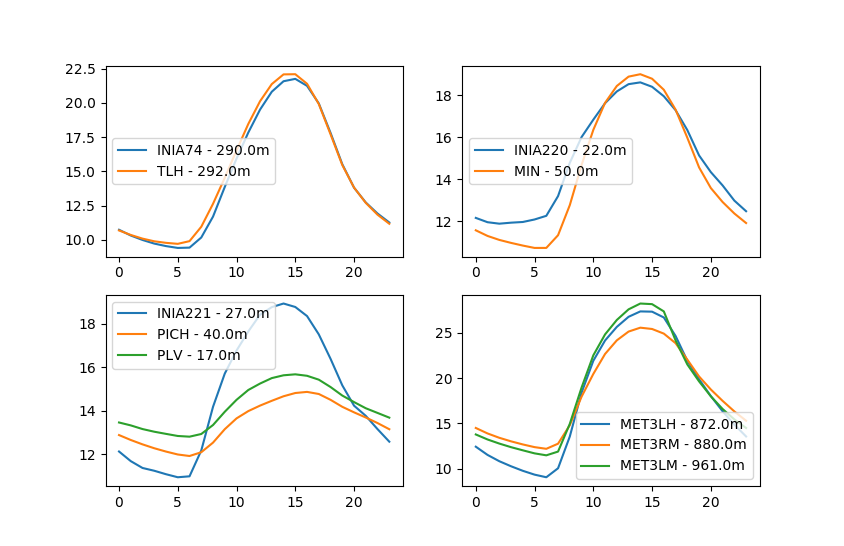

In [76]:
plt.figure()
plt.subplot(2, 2, 1)
for s in ['INIA74', 'TLH']:
    z = Z.sel(space=s).item()
    plt.plot(x.hour, x.sel(space=s).values, label='{} - {}m'.format(s, z))
plt.legend()
plt.subplot(2, 2, 2)
for s in ['INIA220', 'MIN']:
    z = Z.sel(space=s).item()
    plt.plot(x.hour, x.sel(space=s).values, label='{} - {}m'.format(s, z))
plt.legend()
plt.subplot(2, 2, 3)
for s in ['INIA221', 'PICH', 'PLV']:
    z = Z.sel(space=s).item()
    plt.plot(x.hour, x.sel(space=s).values, label='{} - {}m'.format(s, z))
plt.legend()
plt.subplot(2, 2, 4)
for s in ['MET3LH', 'MET3RM', 'MET3LM']:
    z = Z.sel(space=s).item()
    plt.plot(x.hour, x.sel(space=s).values, label='{} - {}m'.format(s, z))
plt.legend()

In [57]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


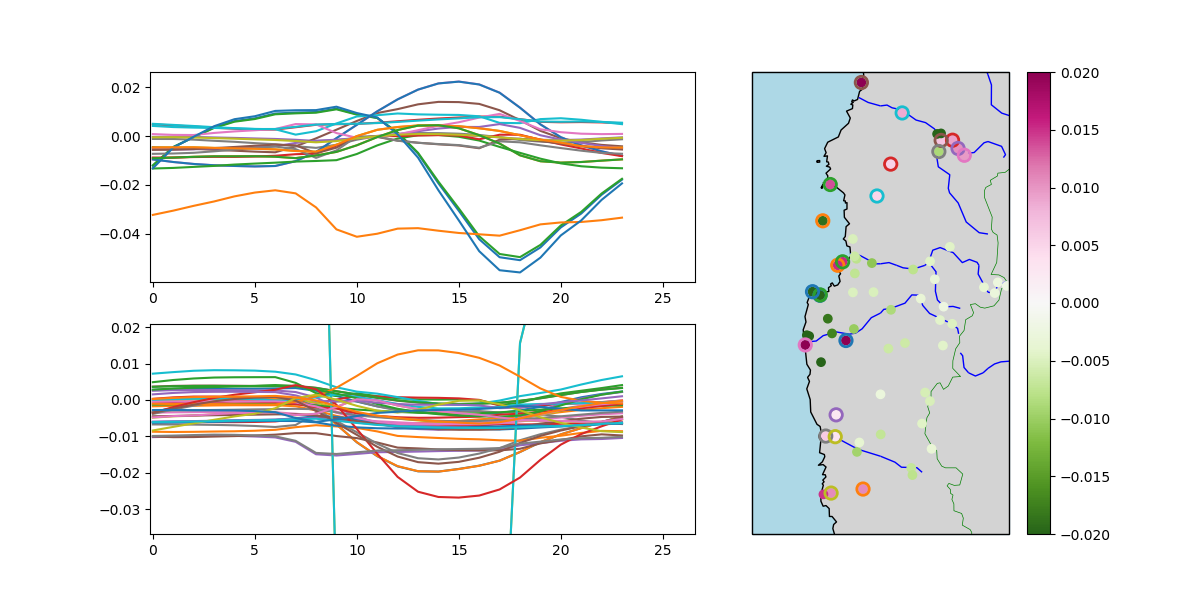

In [29]:
fig = plt.figure(figsize=(12, 6))
g = gs.GridSpec(2, 5)

plt.subplot(g[0, :3])
pl = plt.plot(b);

plt.subplot(g[1, :3], sharex=pl[0].axes)
plt.plot(c);
# plt.plot(np.roll(lr0.groupby('hour').mean(), -4), linewidth=5, color='k')

plt.subplot(g[:, 3:], projection=crs.PlateCarree())
plt.scatter(*ll[:, l>0], c=amp(b).values, vmin=-.02, vmax=.02, cmap='PiYG_r')
plt.scatter(*ll[:, l<0], c=amp(c).values, vmin=-.02, vmax=.02, cmap='PiYG_r')
plt.colorbar()

plt.scatter(*ll[:, l>0], facecolors='none', edgecolors=[p.get_color() for p in pl],
           s=80, linewidth=2)
coq(plt.gca())

In [96]:
db = b.sel(hour=[6, 14]).diff('hour')
db.isel(space=db.argsort().values.flatten()).isel(space=slice(-5, None))

<xarray.DataArray (hour: 1, space: 5)>
array([[0.017894, 0.019335, 0.019656, 0.020647, 0.037781]])
Coordinates:
  * space    (space) object 'MARPCH' 'INIA221' 'PICH' 'CHPL' 'MARIP'
    var      <U4 'elev'
Dimensions without coordinates: hour

In [100]:
sta.loc[b.isel(space=b.sel(hour=[6, 14]).diff('hour').argsort().values.flatten()).space[-5:]]

full        lon        lat elev                first  \
station                                                                     
MARPCH    Punta de Choros  -71.46797  -29.24724    7  2011-01-04 11:00:00   
INIA221  Quilimari [INIA]  -71.46001  -32.11910   27  2017-09-01 00:00:00   
PICH          Pichidangui  -71.53137  -32.13106   40  2014-04-09 13:30:00   
CHPL          Punta Lobos  -71.17817  -28.29765    1  2011-01-01 00:10:00   
MARIP      Islote Pájaros  -71.53750  -29.58510   39  2011-01-12 12:00:00   

                        last  
station                       
MARPCH   2018-03-21 08:00:00  
INIA221  2018-02-25 07:00:00  
PICH     2017-11-29 13:45:00  
CHPL     2013-08-20 04:50:00  
MARIP    2018-03-20 17:30:00

In [6]:
T2 = hh.stationize(D['ta_c'].xs('prom', 1, 'aggr').drop('10', 1, level='elev'))

In [7]:
ds = xr.open_dataarray('/HPC/arno/data/T2.nc')

# should work for the whole dataset independent of start hour (uses XTIME)
dt = ds - WRF.align_stations(ds, T2) - 273.15

In [158]:
dmab = xr.concat((da, db), 'start').stack(t=('start', 'Time')).mean('t')

In [145]:
dtm = dt.stack(t=('start', 'Time')).mean('t')

In [20]:
ll = sta.loc[dt.station][['lon', 'lat']].astype(float).as_matrix().T

In [168]:
xa = da.sel(station='8', Time=slice(24, 47)).stack(t=('start', 'Time')).sortby('XTIME').dropna('t')
xb = db.sel(station='8', Time=slice(24, 47)).stack(t=('start', 'Time')).sortby('XTIME').dropna('t')

In [15]:
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
from scipy.stats.distributions import norm

In [59]:
k = gaussian_kde(x)

In [66]:
gm = GaussianMixture(n_components=2).fit(x.values.reshape((-1, 1)))

In [69]:
gm.fit(x.values.reshape((-1, 1)))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>


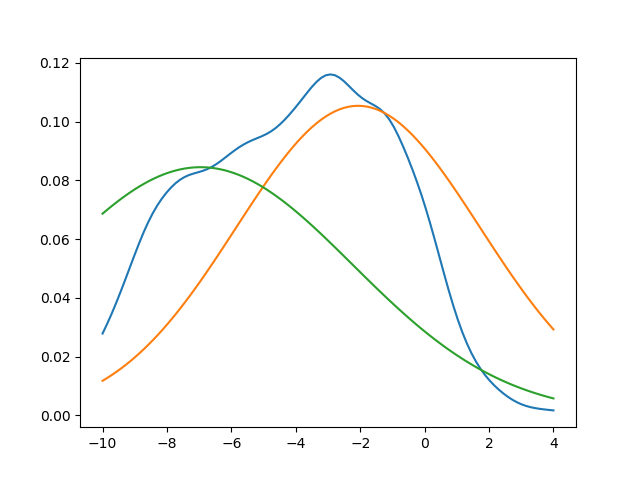

In [80]:
k = gaussian_kde(x)
gm = GaussianMixture(n_components=2).fit(x)

i = np.linspace(-10, 4, 100)
plt.figure()
plt.plot(i, k(i))
for loc, prec in zip(gm.means_.flatten(), gm.precisions_.flatten()):
    plt.plot(i, norm(loc, 1/prec).pdf(i))

In [169]:
loc, prec = [], []
for t in np.unique(xb.Time):
    gm.fit(xb.sel(Time=t).values.reshape((-1, 1)))
    loc.append(gm.means_.flatten())
    prec.append(gm.precisions_.flatten())

In [170]:
j = np.array([sorted(l) for l in loc])

In [45]:
from data.interpolate import GridInterpolator

In [48]:
ds = WRF.Files.first('d03')
gi = GridInterpolator(ds)
z = gi.xarray(ds['HGT'][0, :, :])

In [39]:
%matplotlib nbagg

In [69]:
s = lambda x: x.sel(Time=slice(24, 47)).stack(t=('start', 'Time')).sortby('XTIME').dropna('station', 'all')
da = s(dt.sel(start=dt.indexes['start'].hour==20)) / z
db = s(dt.sel(start=dt.indexes['start'].hour==8)) / z

In [132]:
def gauss_mixt(x):
    loc, prec = [], []
    n = lambda s: s[np.isfinite(s)]
    for t in np.unique(x.Time):
        gm.fit(n(x.sel(Time=t).values).reshape((-1, 1)))
        loc.append(gm.means_.flatten())
        prec.append(gm.precisions_.flatten())
    return loc, prec
    return np.array(loc)[np.where(np.array([np.argsort(p) for p in prec]))]

In [130]:
la = gauss_mixt(da)
lb = gauss_mixt(db.sel(t=slice(None, pd.Timestamp('2017-04-24'))))
# lc = gauss_mixt(db.sel(t=slice(pd.Timestamp('2017-04-24'), None)))

<IPython.core.display.Javascript object>


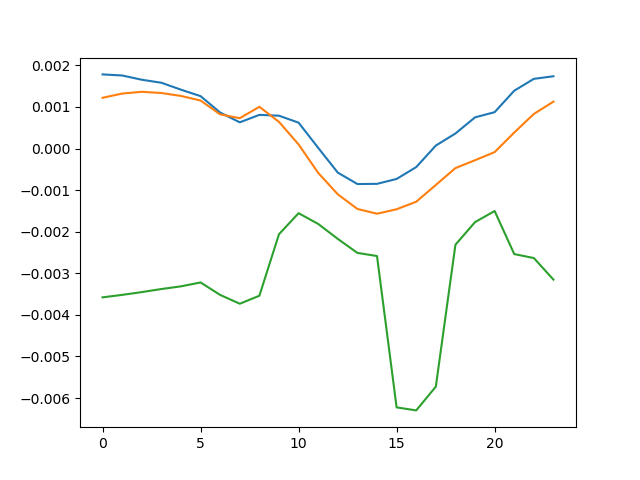

In [131]:
plt.figure()
plt.plot(np.roll(la, -4))
plt.plot(np.roll(lb, 8))
plt.plot(np.roll(lc, 8))

Daily cycles of lapse rates as devined by applying a two-distribution Gaussian mixture to the difference WRF - station data (all station data, more or less yearly periods per one of the three lines).

I think there are still errors in the data compilation from the WRF simulations, which is why the line corresponding to the last year (mid-2017 to mid-2018, green) looks so erratic. **However**, it does appear that even with the correct data from WRF (below), there is a difference in the average lapse rates between the years.

In [2]:
TGP1 = xr.open_dataset('/home/arno/code/T_GP0.nc')

In [11]:
TGP2 = xr.open_dataset('/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_0.nc')

In [8]:
lr1 = (lambda x: x['T'] / x['GP'])(TGP1[['T', 'GP']].sel(bottom_top=[0, 1]).diff('bottom_top')).squeeze()

/HPC/arno/conda/envs/uvi/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:137: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


In [12]:
lr2 = (lambda x: x['T'] / x['GP'])(TGP2[['T', 'GP']].sel(bottom_top=[0, 1]).diff('bottom_top')).squeeze()

/HPC/arno/conda/envs/uvi/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:137: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


<IPython.core.display.Javascript object>


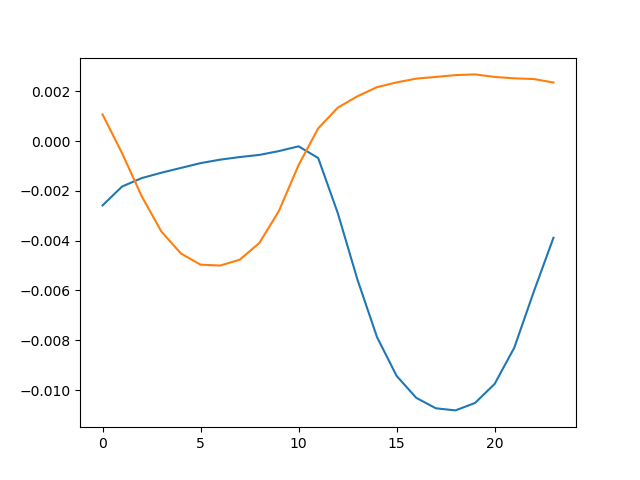

In [13]:
plt.figure()
plt.plot(lr2.sel(Time=slice(24, 47)).mean(('start', 'station')))
plt.plot(lr.sel(start=slice('2017-04-24', None), Time=slice(24, 47)).mean(('start', 'station')))

In [14]:
lr.sel(Time=slice(24, 47)).isel(start=0, station=14)

<xarray.DataArray (Time: 24)>
array([-0.013991, -0.12455 ,       nan, -0.152881, -0.16258 ,       nan,
             nan,       nan, -0.173064,       nan, -0.070299, -0.24723 ,
             nan,  0.11605 ,  0.004245,  0.006045,  0.11643 ,       nan,
       -0.170569, -0.190483,       nan,       nan,       nan, -0.233615])
Coordinates:
  * Time        (Time) int64 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 ...
    XTIME       (Time) datetime64[ns] 2016-12-02T08:00:00 ...
    start       datetime64[ns] 2016-12-01T08:00:00
    station     <U5 'CHILL'
    bottom_top  int64 1

In [17]:
np.where(TGP['T'].isel(start=100, station=10, bottom_top=[0, 1]).isnull())

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]),
 array([ 13,  16,  17,  19,  26,  28,  38,  46,  49,  50,  51,  56,  70,
         93,  96,  97,  99, 106, 108, 118, 126, 129, 130, 131, 136,   5,
         28,  31,  32,  34,  41,  43,  53,  61,  64,  65,  66,  71,  85,
        108, 111, 112, 114, 121, 123, 133, 141, 144]))

In [17]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(20000))

In [22]:
L.regress(Z, Tr.sel(time=slice('2017-04', None)), 0.)

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.109152623547898e-24 / 1.1102230246251565e-16
  RuntimeWarning)


In [26]:
b = [by_hour(L, Tr.sel(time=slice('2017-04', None)), h)[0].item() for h in range(24)]

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.153815394235526e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.225423233738765e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.310440286592486e-24 / 1.1102230246251565e-16
  RuntimeWarning)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3

<IPython.core.display.Javascript object>


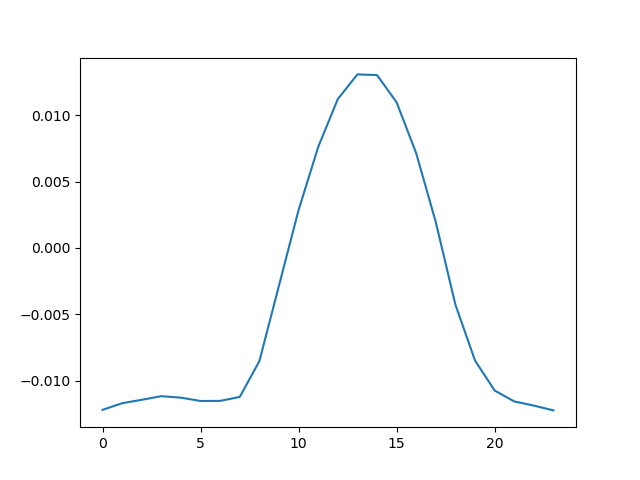

In [28]:
plt.figure()
plt.plot(b)

In [11]:
T2wrf = xr.open_dataarray('/HPC/arno/data/T2.nc')

In [10]:
DTwrf = xr.open_dataset('/HPC/arno/data/T_GP_2015-18.nc')

In [12]:
DTwrf.indexes['start'].get_duplicates()

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [98]:
DT2 = xr.open_dataset('/sshfs/datos/sata1_ceazalabs/arno/HPC/uvHome/code/python/T_GP_10.nc')

In [138]:
j = set(range(DT2.start.size)) - \
    set([DT2.indexes['start'].get_indexer_for([i])[0] for i in DT2.indexes['start'].get_duplicates()])

In [140]:
x = DT2.isel(start=list(j))

In [ ]:
x - DTwrf

In [84]:
lr = DTwrf['T'].isel(bottom_top=[0, 1]).diff('bottom_top') / DTwrf['GP'].isel(bottom_top=[0, 1]).diff('bottom_top')
lr.coords['hour'] = ('Time', lr.Time % 24)

In [ ]:
dt = ds - WRF.align_stations(ds, T2) - 273.15

In [13]:
Terr = T2wrf - WRF.align_stations(T2wrf, T2) - 273.15

In [17]:
terr = Terr.values.flatten()
k = gaussian_kde(terr[np.isfinite(terr)])

In [20]:
np.nanmin(terr)

-28.327515280569173

In [21]:
np.nanmax(terr)

22.685240471706265

In [25]:
DTwrf

<xarray.Dataset>
Dimensions:     (Time: 169, bottom_top: 29, start: 961, station: 80)
Coordinates:
  * Time        (Time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * bottom_top  (bottom_top) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * station     (station) object '21' '3' '4' '5' '6' '8' '9' 'ANDA' 'BK' ...
  * start       (start) datetime64[ns] 2015-05-18T20:00:00 ...
    XTIME       (start, Time) datetime64[ns] ...
Data variables:
    GP          (start, station, Time, bottom_top) float64 ...
    T           (start, station, Time, bottom_top) float64 ...

In [27]:
lr = (lambda x: x['T']/x['GP'])(DTwrf.sel(bottom_top=[0,1]).diff('bottom_top'))

KeyboardInterrupt: 

In [28]:
lr = xr.open_dataarray('/HPC/arno/data/lapse_2015-18.nc')

In [51]:
dz = (z - Z.rename({'space': 'station'}).sel(var='elev'))
dt = dz * lr

In [126]:
dna = lambda x: x[np.isfinite(x)]

k1 = gaussian_kde(dna(Terr.values.flatten()))
k2 = gaussian_kde(dna((Terr - dt).values.flatten()))
k3 = gaussian_kde(dna((Terr - Terr.mean(('start','Time'))).values.flatten()))

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:127: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


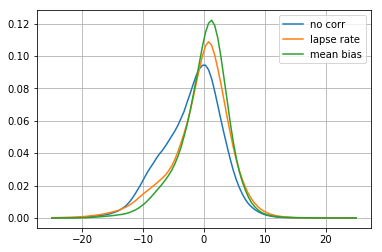

In [127]:
x = np.linspace(-25, 25, 100)
plt.figure()
plt.plot(x, k1(x), label='no corr')
plt.plot(x, k2(x), label='lapse rate')
plt.plot(x, k3(x), label='mean bias')
plt.grid('on')
plt.legend()

In [62]:
plt.legend(['no corr', 'lapse rate', 'mean bias'])

In [57]:
dt.mean()

<xarray.DataArray ()>
array(-1.4851154045642672)
Coordinates:
    var      <U4 'elev'

In [78]:
mm = xr.open_dataset('/HPC/arno/data/lapse_field_monthly_2015-16.nc')

In [101]:
cntrs = np.arange(-0.012, 0.013, 0.002)

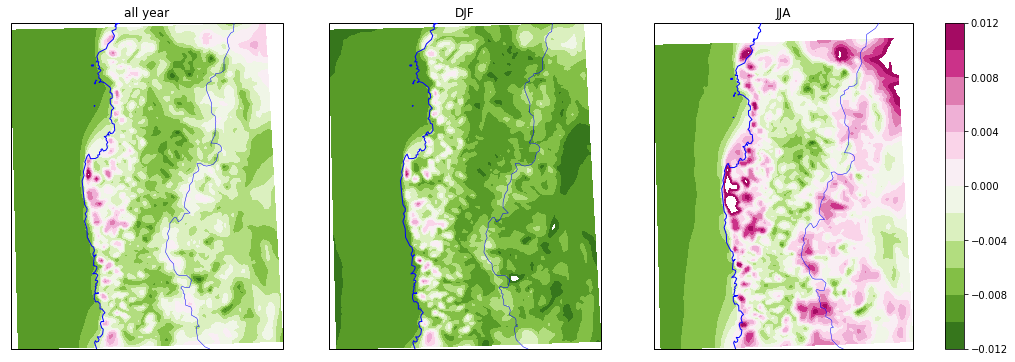

In [115]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': crs.PlateCarree()}, figsize=(17, 6))
fig.subplots_adjust(wspace=0.02)

plt.set_cmap('PiYG_r')

plt.sca(axs[0])
plt.contourf(mm.XLONG[1,:,:], mm.XLAT[1,:,:], mm['LR'].mean(('Time', 'month')).squeeze(),
            cntrs)
coq(plt.gca(), lines_only=True, colors=['b'])
plt.title('all year')

plt.sca(axs[1])
plt.contourf(mm.XLONG[1,:,:], mm.XLAT[1,:,:], mm['LR'].sel(month=[1, 2, 12]).mean(('Time', 'month')).squeeze(),
            cntrs)
coq(plt.gca(), lines_only=True, colors=['b'])
plt.title('DJF')

plt.sca(axs[2])
pl = plt.contourf(mm.XLONG[1,:,:], mm.XLAT[1,:,:], mm['LR'].sel(month=[6, 7, 8]).mean(('Time', 'month')).squeeze(),
            cntrs)
coq(plt.gca(), lines_only=True, colors=['b'])
plt.title('JJA')

bb = axs[2].get_position()
plt.colorbar(pl, cax=fig.add_axes([bb.x1+0.005, bb.y0, 0.015, bb.height]))

In [122]:
sta.loc['LLL']

full     Llano de Las Liebres
lon                 -69.93699
lat                 -30.25741
elev                     3565
first     2017-05-16 10:00:00
last      2018-03-21 07:00:00
Name: LLL, dtype: object